In [115]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

In [116]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def to_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

def to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def warp_perspective(img,mat):
    return cv2.warpPerspective(img ,mat ,(1280,720))
    
def PerspectiveTransform(src,dst):
    mat = cv2.getPerspectiveTransform(src,dst)
    mat_inv = cv2.getPerspectiveTransform(dst,src)
    return mat,mat_inv

def isolate_color_mask(img, low_thresh, high_thresh):
    return cv2.inRange(img, low_thresh, high_thresh)


def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    return img


def get_aoi(img):
    rows, cols = img.shape[:2]
    mask = np.zeros_like(img)
    
    left_bottom = [cols * 0.1, rows]
    right_bottom = [cols * 0.95, rows]
    left_top = [cols * 0.4, rows * 0.6]
    right_top = [cols * 0.6, rows * 0.6]
    
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    
    if len(mask.shape) == 2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255, ) * mask.shape[2])
    return cv2.bitwise_and(img, mask)
    

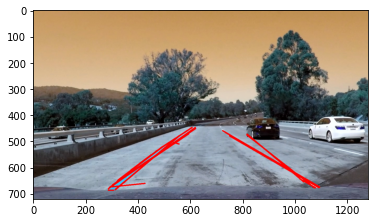

In [119]:
img=cv2.imread(r"Assets\Project_data\test_images\test1.jpg")


rows, cols = img.shape[:2]
mask = np.zeros_like(img)

input_top_left = [500,480]
input_top_right = [780,480]
input_bottom_right = [1200,700]
input_bottom_left = [250,700]
srcPts = np.float32([input_bottom_left,input_top_left,input_top_right,input_bottom_right])
dstPts = np.float32([[0,720],[0,0],[1280,0],[1280,720]])



mat,mat_inv = PerspectiveTransform(srcPts,dstPts)
bird_view = warp_perspective(img,mat)

gray_img = grayscale(bird_view)
darkened_img = adjust_gamma(gray_img, 0.5)
white_mask = isolate_color_mask(to_hls(img), np.array([0, 200, 0], dtype=np.uint8), np.array([200, 255, 255], dtype=np.uint8))
yellow_mask = isolate_color_mask(to_hls(img), np.array([10, 0, 100], dtype=np.uint8), np.array([40, 255, 255], dtype=np.uint8))
mask = cv2.bitwise_or(white_mask, yellow_mask)
colored_img = cv2.bitwise_and(darkened_img, darkened_img, mask=mask)
blurred_img = gaussian_blur(colored_img, kernel_size=7)


edges = cv2.Canny(blurred_img,70,140)

aoi_img = get_aoi(edges)

lines =cv2.HoughLinesP(aoi_img,1,np.pi/180,20,minLineLength=20,maxLineGap=300)
hough_img = draw_lines(img, lines)


plt.imshow(hough_img)


In [123]:
cap = cv2.VideoCapture(r"Assets\Project_data\project_video.mp4")
while cap.isOpened():
  ret,img = cap.read()
  if not ret:
      break
    
  
    
  mat,mat_inv = PerspectiveTransform(srcPts,dstPts)
  bird_view = warp_perspective(img,mat)
  gray_img = grayscale(bird_view)
  darkened_img = adjust_gamma(gray_img, 0.5)
  white_mask = isolate_color_mask(to_hls(bird_view), np.array([0, 200, 0], dtype=np.uint8), np.array([200, 255, 255], dtype=np.uint8))
  yellow_mask = isolate_color_mask(to_hls(bird_view), np.array([10, 0, 100], dtype=np.uint8), np.array([40, 255, 255], dtype=np.uint8))
  mask = cv2.bitwise_or(white_mask, yellow_mask)
  colored_img = cv2.bitwise_and(darkened_img, darkened_img, mask=mask)
  blurred_img = gaussian_blur(colored_img, kernel_size=7)


  edges = cv2.Canny(blurred_img,70,140)
  

  lines =cv2.HoughLinesP(edges,1,np.pi/180,20,minLineLength=20,maxLineGap=300)
  try: 
    hough_img = draw_lines(bird_view, lines)
  except:
    pass
    
  re_gen = warp_perspective(hough_img,mat_inv)
    
  cv2.addWeighted(img, 1, re_gen, 1,0, img)

  cv2.imshow("name",bird_view)
    
    
  if cv2.waitKey(25) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()
